## SIR-X

Coronavirus COVID-19 is a pandemic that is spreading quickly worlwide. Up to the 29th of March, there are 666,211 cases confirmed, 30,864 deaths and 141,789 recovered people worldwide. Governments and citizens are taking quick decisions to limit the spread of the virus and minimize the number of infected and deaths. These decisions are taken based on the experts opinion, which justify their claims based in the results of predictive models.


This Jupyter Notebook is an effort to decrease the access barriers to state of the art yet simple models that can be used to take public policy decisions to limit disease spread and save lives. 

### SIR model

Most epidemic models share a common approach on modelling the spread of a disease. The SIR model is a simple deterministic compartmental model to predict disease spread. An objective population is divided in three groups: the susceptible ($S$), the infected ($I$) and the recovered or removed ($R$). These quantities enter the model as fractions of the total population $P$:


$$ S = \frac{\text{Number of susceptible individuals}}{\text{Population size}}$$

$$ I = \frac{\text{Number of infected individuals}}{\text{Population size}}$$

$$ R = \frac{\text{Number of recovered or removed individuals}}{\text{Population size}}$$

As a pandemics infects and kills much more quickly than human natural rates of birth and death, the population size is assumed constant except for the individuals that recover or die. Hence, $S+I+R=P/P=1$. The pandemics dynamics is modelled as a system of ordinary differential equations which governs the rate of change at which the percentage of susceptible, infected and recovered/removed individuals in a population evolve.

The number of possible transmissions is proportional to the number of interactions between the susceptible and infected populations, $S \times I $:

$$\frac{dS}{dt} = -\alpha SI.$$

Where $\alpha$ is the reproduction rate of the process which quantifies how many of the interactions between susceptible and infected populations yield to new infections per day.

The population of infected individuals will increase with new infections and decrease with recovered or removed people. 

$$\frac{dI}{dt} = \alpha S I  - \beta I, $$
$$\frac{dR}{dt} = \beta I. $$

Where $ \beta $ is the percentage of the infected population that is removed from the transmission process per day.

In early stages of the infection, the number of infected people is much lower than the susceptible populations. Hence, $S \approx 1$ making $dI/dt$ linear and the system has the analytical solution $I(t) = I_0 \exp (\alpha - \beta)t$.



#### Numerical implementation - SIR model

Three python packages are imported: numpy for numerical computing, matplotlib.pyplot for visualization and the numerical integration routine odeint from scipy.integrate:

In [1]:
import numpy as np # Numerical computing
import matplotlib.pyplot as plt # Visualization
from scipy.integrate import odeint # ODE system numerical integrator

Implementing systems of ordinary differential equations (ODEs) in python is straightforward. First, a function is created to represent the system inputs and outputs. The inputs of the function are a vector of state variables ${\vec{w}}$, the independent variable $t$ and a vector of parameters $\vec{p}$. The output of the function must be the right hand side of the ODE system as a list.

Following this approach, the SIR model can be implemented as it follows:

$$ \vec{w} = [S,I,R]$$
$$ \vec{p} = [\alpha, \beta] $$

And $t$ enters directly. The function return will be the list of ODEs.

$$\vec{f} = \left[ \frac{dS}{dt}, \frac{dI}{dt}, \frac{dR}{dt} \right]$$

So $\vec{f} = \text{sir}(\vec{w}, t, \vec{p})$.

#### Function definition: sir model

In [2]:
def sir(w, t, p):
    """ SIR: Simple model of disease spread
    inputs:
    w: vector of state variables [S,I,R]
    S: Fraction of the population susceptible to the infection
    I: Fraction on the population infected
    R: Fraction of the population recovered
    
    returns:
    f: right hand side of the system of differential equations
    """
    # Unpack state variables
    S, I, R = w
    # Unpack parameters
    alpha, beta = p
    dS_dt = -alpha*S*I
    dI_dt =  alpha*S*I - beta*I
    dR_dt = beta * I
    
    f = [dS_dt, dI_dt, dR_dt]
    return f

### Usage example

#### Case study

The borough of Ealing, in London, is selected arbitrarly as one of the authors is living there at the moment. According to the UK office for National Statistics, the population of Ealing by mid-year 2018 is [342.000](https://www.ealing.gov.uk/info/201048/ealing_facts_and_figures/2184/population_and_households/1). The number of reported infections at 29/03/2020 is 241.

#### Model parameters
As an implementation examples, the parameter $\beta$ is estimated from the methodology followed by the [Robert Koch Institut SIRX model webiste](http://rocs.hu-berlin.de/corona/docs/forecast/model/#sir-x-dynamics-outbreaks-with-temporally-increasing-interventions). The institute estimated the a removal rate value $\beta = 0.38/d$ (mean infections time $T_I = 1/\beta = 2.6d)$ based on one third of the reported average infections preioud of moderate cases in Mainland China.

The reproduction number is fixed $R_0 = \alpha / \beta = 2.5$ as a first approximation. 

Please note that the predictions of this model shouldn't be taken in consideratin, as the SIR model doesn't consider dynamic variation of model parameters, which is observed in reality.

#### Model inputs

In [3]:
# Use Ealing as an example to determine model initial conditions
P_Ealing = 342000 # Ealing population ONS 2018 mid year
I_Ealing = 241    # Infected people at 29/03/2020
R_Ealing = 0      # Recovered people at 29/03/2020
n_days = 30

# Input parameters
beta = 0.38/(3600*24) # Per day
alpha = 2.5 * beta # WHO estimate

#### Calculate model parameters and initial conditions

In [4]:
# Calculate initial conditions in terms of population fraction
S0 = (P_Ealing-I_Ealing)/P_Ealing
I0 = I_Ealing/P_Ealing
R0 = R_Ealing/P_Ealing      # Recovered people

# Construct vector of parameters
p = [alpha, beta]

# Construct vector of initial conditions
w0 = [S0, I0, R0]

# ODE solver parameters (optional)
abserr = 1.0e-8  #
relerr = 1.0e-6  #

tf = 3600*24*n_days   # Final time in seconds
numpoints = n_days+1 #

# Create time vector to input to the integrator odeint
t = np.linspace(0, tf,numpoints)

### Solution

The integrating routine *odeint* requires for parameters that were previously defined:

* func: function to be integrated. In this case, we defined **sir**
* y0: vector of initial conditions of the state variables. In this case, **w0**
* t: discrete time-steps where the solutions is going to be evaluated. In this case, **t**
* args = (): Extra arguments to pass to function. In our case, is the vector of parameters **p**

In [5]:
wsol = odeint(func = sir, y0 = w0, t = t, args=(p,), atol=abserr, rtol=relerr)

In [6]:
type(wsol)

numpy.ndarray

## Unpacking the solution
wsol is a numpy.ndarray which contains the solution of each state variable. It can be unpacked easily slicing the numpy array.

In [7]:
# Unpack the solution
# R = 1.5
S = wsol[:,0] 
I = wsol[:,1]
R = wsol[:,2]

# Multiply by population size to convert model solutions into number of people

S_n = S*P_Ealing
I_n = I*P_Ealing
R_n = R*P_Ealing

### Plotting

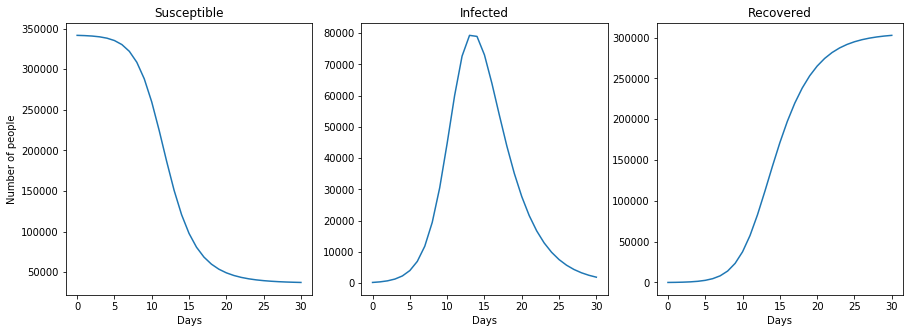

In [8]:
# This visualization is useful and could be packed
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.plot(t/(3600*24),S_n)
plt.xlabel('Days')
plt.ylabel("Number of people")
plt.title("Susceptible")
plt.subplot(1,3,2)
plt.plot(t/(3600*24),I_n)
plt.xlabel('Days')
plt.title("Infected")
plt.subplot(1,3,3)
plt.plot(t/(3600*24),R_n)
plt.title("Recovered")
plt.xlabel('Days')
plt.show()

It can be observed that the SIR model reproduces the all familiar infection bell, as well as the evolution of susceptible and recovered population. It is interesting to observe that if no measures are taken in a $R_0 = 2.5$ scenario, 89% of the Ealing population would be infected in a month.

### Sensitivity to $R_0$

A known weakness of all pandemics prediction model is the sensitivity to their parameters. In the following case study, $R_0$ will be fitted to minimize the mean squared error between the model predictions and UK historical data on the Ealing borough in the time period between the 15th and the 29th of March of 2020.

In [9]:
# Call the ODE solver.
beta = 0.38/(3600*24) # Per day
alpha = 1.6 * beta # Reproduction number
P_Ealing = 342000 # Ealing population
I_Ealing = 8    # Infected people at 15/03/2020

S0 = (P_Ealing-I_Ealing)/P_Ealing
I0 = I_Ealing/P_Ealing
w0 = [S0, I0, R0]
p = [alpha,beta]
# ODE solver parameters
abserr = 1.0e-8  #
relerr = 1.0e-6  #
n_days = 15
tf = 3600*24*n_days   # Final time in seconds
numpoints = n_days+1 #

t_hist = np.linspace(0, tf,numpoints)
# Use Ealing values
wsol_hist = odeint(sir, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

The function compare_infections is defined to obtain the a list of lists of infected people for different combinations of parameters. In the first implementation, it only allows variations to the alpha parameter.

In [10]:
def compare_infections(w0, t, p, func, alpha_list=2.5, abserr=1e-8, relerr=1e-6):
    """ compare_infections compare SIR model predictions against
    a list of alpha values
    
    Inputs:
    w0: Initial conditions
    t: Time vector
    p: Parameters
    alpha_list: list or numpy array of values of alpha to be tested
    
    Outputs:
    S_list: List of predictions for the fraction of susceptible population for each alpha
    I_list: List of predictions for the fraction of infected population for each alpha
    R_list: List of predictions for the fraction of recovered/removed population for each alpha
    """
    I_list = []
    S_list = []
    R_list = []
    
    for i in alpha_list:
        # Update parameter list
        p[0] = i
        print(p)
        wsol = odeint(func, w0, t, args=(p,), atol=abserr, rtol=relerr)
        S_list.append(wsol[:,0])
        I_list.append(wsol[:,1])
        R_list.append(wsol[:,2]) 
    return S_list, I_list, R_list

### Generate predictions for each alpha

In [11]:
alpha_list = beta*np.array([1.5,1.6,1.7])
S_list, I_list, R_list = compare_infections(w0, t_hist, p, sir, alpha_list)#

[6.597222222222221e-06, 4.398148148148148e-06]
[7.037037037037037e-06, 4.398148148148148e-06]
[7.476851851851851e-06, 4.398148148148148e-06]


### Plot again daily data of Ealing borough 
[sourced from UK Arcgis](https://www.arcgis.com/apps/opsdashboard/index.html#/f94c3c90da5b4e9f9a0b19484dd4bb14)

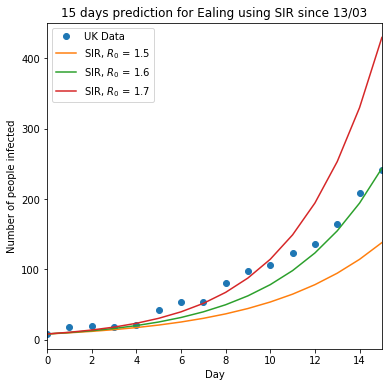

In [12]:
# Daily data of Ealing borough sourced from UK
Ealing_data = [8, 18, 20, 18, 21, 42, 53, 54, 80, 97, 106, 123, 136, 165, 209, 241] # N_of infected
# Convert seconds in days
t_days = t_hist/(3600*24)

plt.figure(figsize=[6,6])
plt.plot(Ealing_data,'o')
plt.plot(t_days, I_list[0]*P_Ealing)
plt.plot(t_days, I_list[1]*P_Ealing)
plt.plot(t_days, I_list[2]*P_Ealing)
plt.legend(["UK Data","SIR, $R_0$ = 1.5","SIR, $R_0$ = 1.6","SIR, $R_0$ = 1.7"])
plt.title("15 days prediction for Ealing using SIR since 13/03")
plt.ylabel("Number of people infected")
plt.xlabel("Day")
plt.xlim([min(t_days),max(t_days)])
plt.show()

The model is extremely sensitive to the reproduction rate parameter $R_0$.

### Fitting $R_0$

In the following case study, $R_0$ will be fitted to minimize the mean squared error between the model predictions and UK historical data on the Ealing borough in the time period between the 15th and the 29th of March of 2020.

# To be completed

### SIR-X model

A new epidemic model based in SIR, SIRX, was developed by the [Robert Koch Institut](http://rocs.hu-berlin.de/corona/docs/forecast/model/#sir-x-dynamics-outbreaks-with-temporally-increasing-interventions) and is implemented in what follows. A full description of the model is available in the [Robert Koch Institut SIRX model webiste](http://rocs.hu-berlin.de/corona/docs/forecast/model/#sir-x-dynamics-outbreaks-with-temporally-increasing-interventions)


In [13]:
def sirx(w, t, p):
    """ SIR-X: Dynamic outbreaks with temporally increasing
    interventions
    
    inputs:
    w: vector of state variables [S,I,R,X]
    where 
        S: Fraction of the population susceptible to the infection
        I: Fraction on the population infected
        R: Fraction of the population that recovered
        X: Fraction of the population that is quarantined
        
    t: time
    p: vector of parameters
    
    returns:
    f: right hand side of the system of differential equations
    """
    # Unpack state variables
    S, I, R, X = w
    # Unpack parameters
    alpha, beta, kappa_0, kappa = p
    dS_dt = -alpha*S*I - kappa_0*S
    dI_dt =  alpha*S*I - beta*I - kappa_0*I - kappa*I
    dR_dt = kappa_0*S + beta * I
    dX_dt = (kappa_0 + kappa) * I
    
    
    f = [dS_dt, dI_dt, dR_dt, dX_dt]
    return f